TO DO: 
    0. FIX the data visualisation (min/half hour + hour + day) 

    1. Add more correlation
    2. Add the word treatment for the weather description
      FUTURE work:
       2. Try to add some data treatment with the sensor
       Chceck csv local and cloud
       
    4. Tyding up
           Combine multiple axis in one print
           Add more comments in GOOD english
           

# Orquid data treatment 

This document shows the data treatment for the Orchid project. 
The data is composed of Weather data (time, city, description, temperature, wind speed and humidity) and Presence data(Measurement, Presence). Both of these are in a csv format and will be imported from the ⁨⁨/Data_treatment⁩/ Data_collected⁩/Raw_data file. 

This jupyter notebook shows the process to import, treat, visualize, normalize and correlate this sets of data. This process is essential in the project in order to obtain relevant information from the sensing process. The time series analysis will help us analyse peaks, trends and relations between the data.  
 
 
### Table of content 

 1. [General](#G) 
     1. [Importing packages](#ip)
     2. [Openning files](#of) 
     
 
 2. [Data treatment](#dt) 
     1. [Presence data](#dtp)
     2. [Weather data](#dtw)
 
 3. [Plotting and normalisation](#plt)
     1. [Presence data](#pplt) 
     2. [Weather data](#wplt)
     3. [Data per day](#dplt)
     4. [Normalisation](#cplt) 
     
 4. [Autocorrelation](#ac)
     1. [Presence data](#acp)
     2. [Weather data](#wcp)
 5. [Correlation](#c)
 

  

## 1. General 
<a id="G"></a>

### A. Importing packages 
<a id="ip"></a>

The following code imports all the packages needed during the treatment, time series analysis and corelation analysis of the Orchid project data.

In [198]:
# Importing libraries
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go
%matplotlib inline
plt.style.use('fivethirtyeight') # This is a special style template for matplotlib, highly useful for visualizing time series data
from IPython.display import display
import re
from wordcloud import WordCloud
from textblob import TextBlob
import matplotlib.patches as mpatches

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.graphics import tsaplots
## Packages for analyzing time series
#import string
#import nltk
#import warnings 
#warnings.filterwarnings("ignore", category=DeprecationWarning)
#from nltk.stem.porter import *
#import io

#import texblob

### B. Openning files 
<a id="of"></a>



As previosuly mentioned, this jupyter notebooks analyses presence data and weather data. The following code opens the different data folders. Both datasets will be later treated, in the case of the weather data this will be imported twice -the reason for this will be explained in the data treatment section.

In [36]:
Presence_data = pd.read_csv(
    './Data_collected/Raw_data/Cloud_data/Presence_data.csv',
    index_col='Datetime',
    parse_dates=['Datetime'])

Weather_data = pd.read_csv(
    './Data_collected/Raw_data/Cloud_data/Weather_data.csv',
    index_col='Datetime',
    parse_dates=['Datetime'])

Weather_data_words = pd.read_csv(
    './Data_collected/Raw_data/Cloud_data/Weather_data.csv',
    index_col='Datetime',
    parse_dates=['Datetime'])

Weather_data = Weather_data.iloc[1:] # it ignores the first column which is datetime.
Weahter_data = Weather_data.fillna(method='ffill') 

Presence_data.head()
Weather_data.head()

,Measurement,Presence
Datetime,,
2018-12-25 00:01:00,21.180872,Yes
2018-12-25 00:02:00,27.533214,Yes
2018-12-25 00:03:00,17.493722,Yes
2018-12-25 00:05:00,23.265822,Yes
2018-12-25 00:06:00,21.180872,Yes


,City,Weather,Wind_speed,humidity,temperature
Datetime,,,,,
2018-12-25 00:16:32,Las Palmas de Gran Canaria,clear sky,6.7,32,19
2018-12-25 00:31:34,Las Palmas de Gran Canaria,clear sky,6.2,29,19
2018-12-25 00:46:37,Las Palmas de Gran Canaria,clear sky,6.2,29,19
2018-12-25 01:05:01,Las Palmas de Gran Canaria,clear sky,6.2,25,19
2018-12-25 01:24:16,Las Palmas de Gran Canaria,clear sky,6.7,24,20


The following data gives us information about the length and columns of the different datasets. This will be used as a point of reference througout the time series analysis. 

The presence data contains two coloumns, Measuremenet represents the exact distance at which a person was sensed and Presence is a boulean specifying if there is a presence or not. We will only use the Presence data. 

The weather data contains five coloums, City in which the measurement was taken, weather description, wind speed, humidity and temperature. All the data expect the city information will be used for the data analysis. 

In [37]:
print('PRESENCE DATA:')
Presence_data.info()
print('WEATHER DATA:')
Weather_data.info()

PRESENCE DATA:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2987 entries, 2018-12-25 00:01:00 to 2018-12-31 23:54:00
Data columns (total 2 columns):
Measurement    2987 non-null float64
Presence       2987 non-null object
dtypes: float64(1), object(1)
memory usage: 70.0+ KB
WEATHER DATA:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 668 entries, 2018-12-25 00:16:32 to 2018-12-31 23:58:48
Data columns (total 5 columns):
City           668 non-null object
Weather        668 non-null object
Wind_speed     668 non-null float64
humidity       668 non-null int64
temperature    668 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 31.3+ KB


## 2. Data treatment
<a id="dt"></a>

Both datasets are composed of qualitative and quantitave data. The qualitative data wil be treated and coverted into numerical values - this will allow a to graph and compare this qualitative data with the numerical data, making the analysis more meaninful and utilising all the available sensed data. In this section the data will also be resampled and grouped. Resampling is essential in order to be able to compare both datasets. The weather dataset has been sampled at a repeted frequency whereas the presence data recording frequency cannot be predicted and it is constantly being sampled.  

### A. Presence Data 
<a id="dtp"></a>
In case of the presence data this refers to the boulean option for Presence (Yes or No)- which will be converted into 1 or 0. As the data sensing only recorded the when there was a Presence (Yes) only this parameter will be changed. 

In [38]:
Presence = {'Yes': 1} 

Presence_data.Presence = [Presence[item] for item in Presence_data.Presence] 
Presence_data.head()

,Measurement,Presence
Datetime,,
2018-12-25 00:01:00,21.180872,1
2018-12-25 00:02:00,27.533214,1
2018-12-25 00:03:00,17.493722,1
2018-12-25 00:05:00,23.265822,1
2018-12-25 00:06:00,21.180872,1


The presence data will be cleaned, downsampling presence data per minute and furthermore measuring the number of times a presence has occur on an hourly and dayly sampling rate. When the sampling provides a Nan value, meaning there was no presence activity at that time, we will replace it with a 0.

In [45]:
p_min = Presence_data.resample('T').mean()
p_min = p_min.fillna(0)
p_min.to_csv('./Data_treated/Presence/presence_minute.csv')

activity_hour = Presence_data.groupby(pd.Grouper(freq='H')).size()
#activity_hour.groupby(pd.Grouper(freq='H'), as_index=False).agg({"duration": "sum"})
with open('./Data_treated/Presence/activity_hour.csv', 'w', newline='') as f:
    headers = ['Datetime','Activity_h']
    w = csv.DictWriter(f, fieldnames=headers)
    w.writeheader()
with open('./Data_treated/Presence/activity_hour.csv', 'a') as f:
    activity_hour.to_csv(f, header=False)


activity_day = Presence_data.groupby(pd.Grouper(label = "right",freq='D')).size()
with open('./Data_treated/Presence/activity_day.csv', 'w', newline='') as f:
    headers = ['Datetime','Activity_d']
    w = csv.DictWriter(f, fieldnames=headers)
    w.writeheader()
with open('./Data_treated/Presence/activity_day.csv', 'a') as f:
    activity_day.to_csv(f, header=False)
    
p_min.head()
activity_hour.head()
activity_day

,Measurement,Presence
Datetime,,
2018-12-25 00:01:00,21.180872,1.0
2018-12-25 00:02:00,27.533214,1.0
2018-12-25 00:03:00,17.493722,1.0
2018-12-25 00:04:00,0.000000,0.0
2018-12-25 00:05:00,23.265822,1.0


Datetime
2018-12-25 00:00:00    24
2018-12-25 01:00:00    46
2018-12-25 02:00:00     7
2018-12-25 03:00:00     6
2018-12-25 04:00:00     1
Freq: H, dtype: int64

Datetime
2018-12-26    668
2018-12-27    267
2018-12-28    416
2018-12-29    441
2018-12-30    461
2018-12-31    297
2019-01-01    437
Freq: D, dtype: int64

### B. Weather Data
<a id="dtw"></a>

In case of the weather data we will change its qualitative data, which refers to the weather description values(ranging from clear sky to light rain) and convert into a number in a range of 1-6.  

In [40]:
Weather = {'clear sky': 6,'few clouds' :5, 'scattered clouds':4,'broken clouds': 3,'overcast clouds':2,'light rain':1} 
Weather_data.Weather = [Weather[item] for item in Weather_data.Weather] 
Weather_data.head() 

,City,Weather,Wind_speed,humidity,temperature
Datetime,,,,,
2018-12-25 00:16:32,Las Palmas de Gran Canaria,6,6.7,32,19
2018-12-25 00:31:34,Las Palmas de Gran Canaria,6,6.2,29,19
2018-12-25 00:46:37,Las Palmas de Gran Canaria,6,6.2,29,19
2018-12-25 01:05:01,Las Palmas de Gran Canaria,6,6.2,25,19
2018-12-25 01:24:16,Las Palmas de Gran Canaria,6,6.7,24,20


We will then resample the data with a frequency of half an hour, hour and daily. This will allow us to compare it with the presence data. Sampling the data for a frequency of half an hour and an hour will help us understand if downsampling procedures produce meaningfull data losses and what is the ideal sampling rate in order to procude smooth results and lower the computational expense of the analysis without loosing data. 

In [214]:
w_halfhour = Weather_data.resample('0.5H').mean()
w_halfhour = w_halfhour.fillna(0)
w_halfhour.to_csv('./Data_treated/Weather/weather_halfhour.csv')

w_hour = Weather_data.resample('H').mean()
w_hour= w_hour.fillna(0)
w_hour.to_csv('./Data_treated/Weather/weather_hour.csv')

w_day = Weather_data.resample('D').mean()
w_day.to_csv('./Data_treated/Weather/weather_day.csv')


w_halfhour.head()
w_hour.head()
w_day.head()

,Weather,Wind_speed,humidity,temperature
Datetime,,,,
2018-12-25 00:00:00,6.0,6.70,32.0,19.0
2018-12-25 00:30:00,6.0,6.20,29.0,19.0
2018-12-25 01:00:00,6.0,6.45,24.5,19.5
2018-12-25 01:30:00,6.0,6.95,22.5,20.5
2018-12-25 02:00:00,6.0,6.95,21.5,21.0


,Weather,Wind_speed,humidity,temperature
Datetime,,,,
2018-12-25 00:00:00,6.0,6.366667,30.00,19.00
2018-12-25 01:00:00,6.0,6.700000,23.50,20.00
2018-12-25 02:00:00,6.0,6.950000,21.50,21.00
2018-12-25 03:00:00,6.0,7.200000,22.25,20.75
2018-12-25 04:00:00,5.5,5.550000,24.75,19.50


,Weather,Wind_speed,humidity,temperature
Datetime,,,,
2018-12-25,5.873684,5.256632,40.831579,20.200000
2018-12-26,6.000000,2.515208,55.093750,19.114583
2018-12-27,5.572917,6.087500,54.822917,18.979167
2018-12-28,4.864583,7.103125,72.125000,18.687500
2018-12-29,3.677083,6.640625,62.218750,19.114583


## 3. Plotting and normalisation 
<a id="plt"></a>

Plotting will provide us with an initial information of our data set and the range value sof each data point. 

### A. Presence Data 
<a id="pplt"></a>

Text(0.5,0,'Activity')

Text(0,0.5,'Dates')

Text(0.5,1,"The activity a Lopez's garden in the cityLas Palmas de Gran Canariaover a week(Minute frequency)")

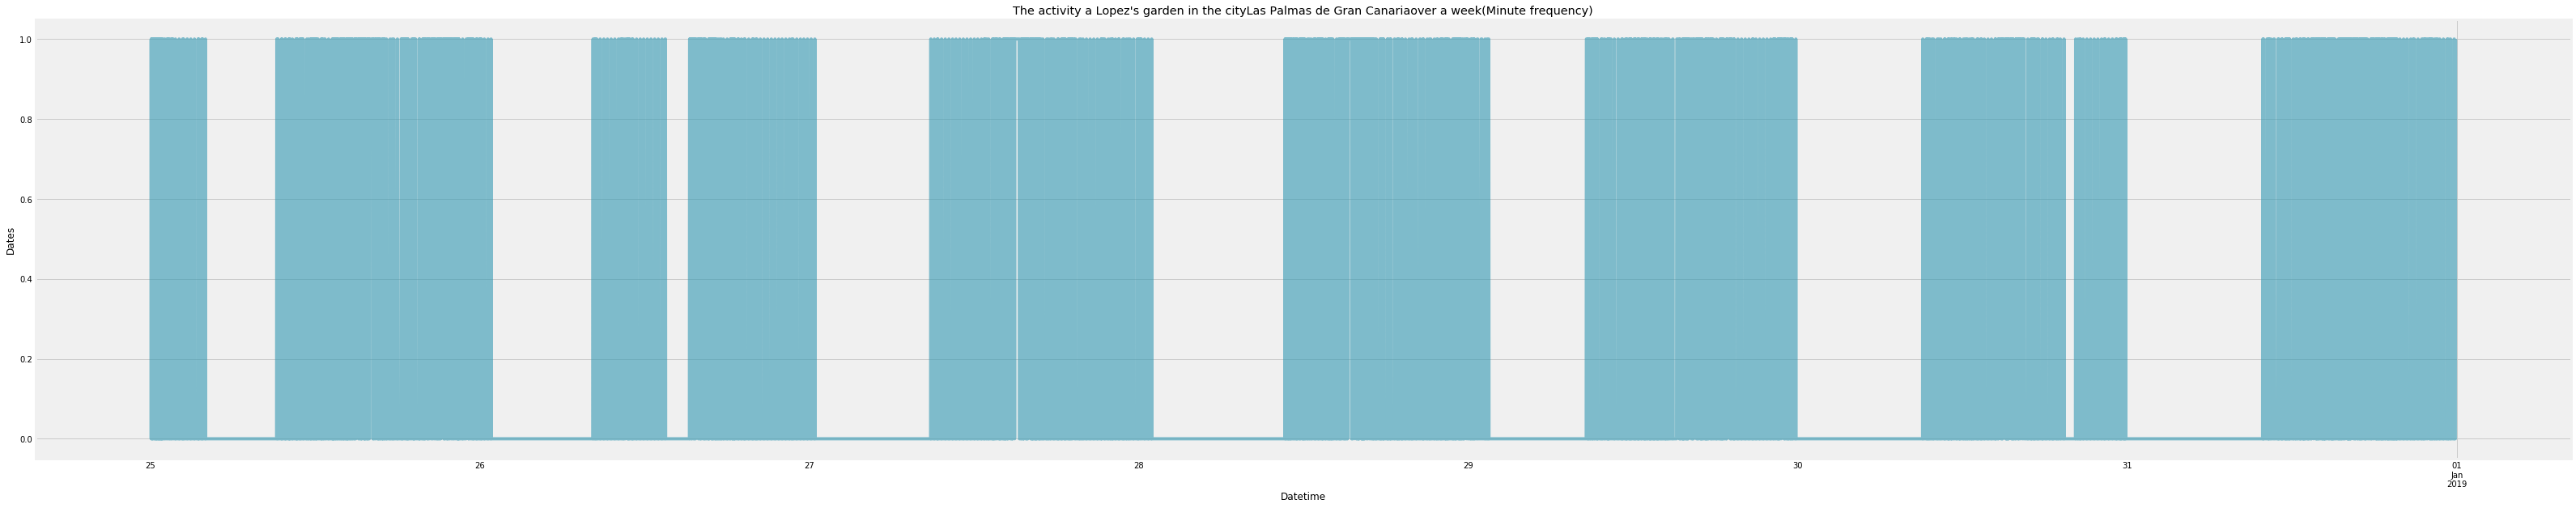

In [47]:
garden = "Lopez's garden"
city = "Las Palmas de Gran Canaria"
plt.xlabel('Activity')
plt.ylabel('Dates')
plt.title("The activity a "+str(garden)+" in the city"+str(city)+"over a week(Minute frequency)")
p_min.Presence.plot(figsize=(50, 10), color=(0.2, 0.6, 0.7, 0.6))

Text(0,0.5,'Activity')

Text(0.5,1,"The activity a Lopez's garden in the cityLas Palmas de Gran Canariaover a week(Hourly frequency)")

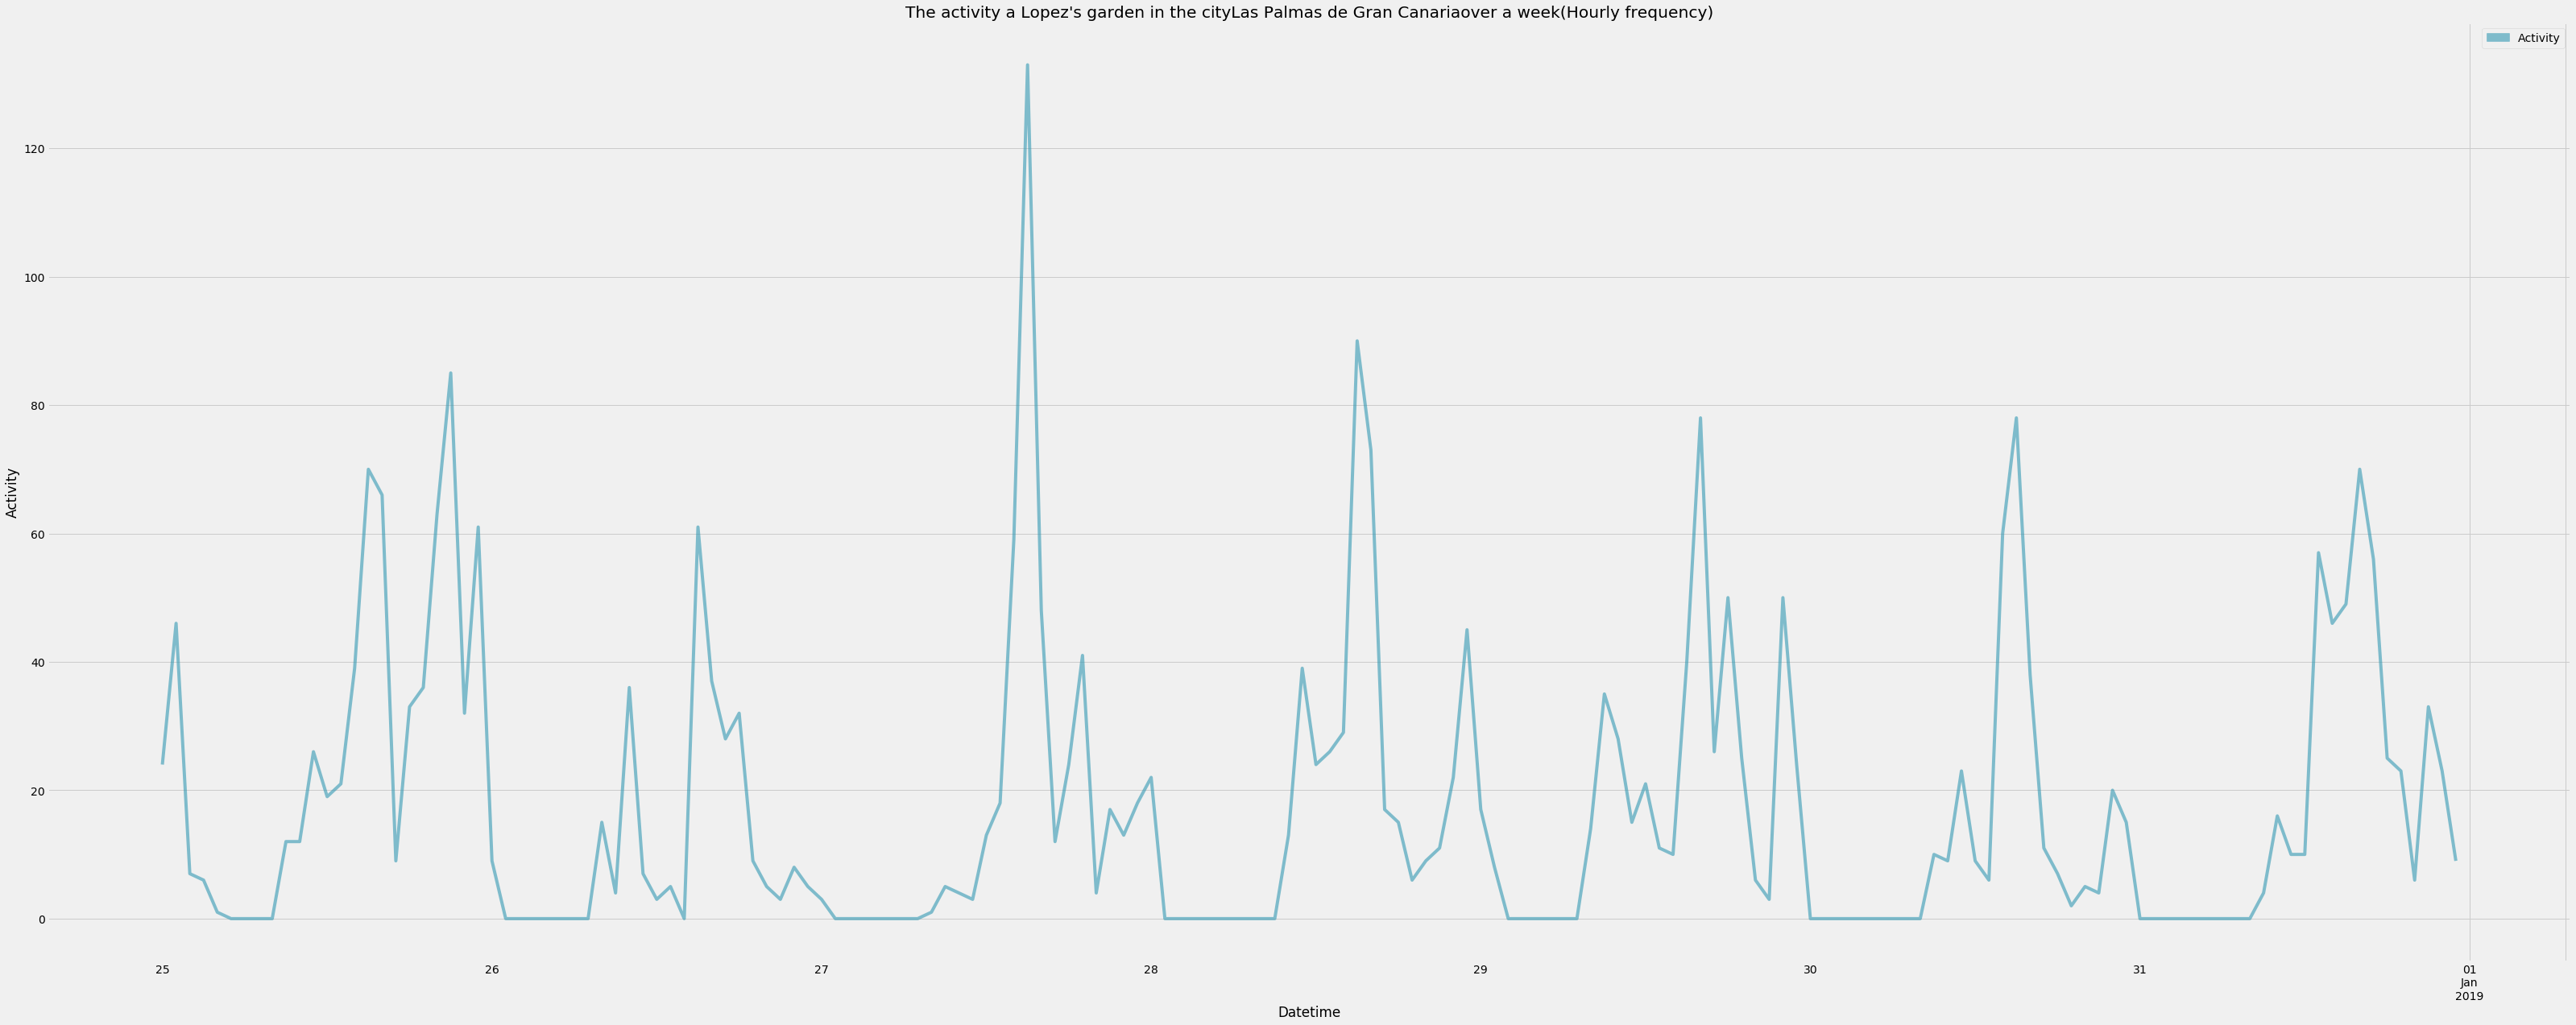

In [79]:
garden = "Lopez's garden"
city = "Las Palmas de Gran Canaria"

plt.ylabel('Activity')
plt.title("The activity a "+str(garden)+" in the city"+str(city)+"over a week(Hourly frequency)")
activity_hour.plot(figsize=(50, 20), color=(0.2, 0.6, 0.7, 0.6))
label1 = mpatches.Patch(color=(0.2, 0.6, 0.7, 0.6), label='Activity')
plt.legend(handles=[label1])
plt.savefig('./graphs/Activity_hour.png')

Text(0,0.5,'Activity')

Text(0.5,1,"The activity a Lopez's garden in the cityLas Palmas de Gran Canariaover a week(Daily frequency)")

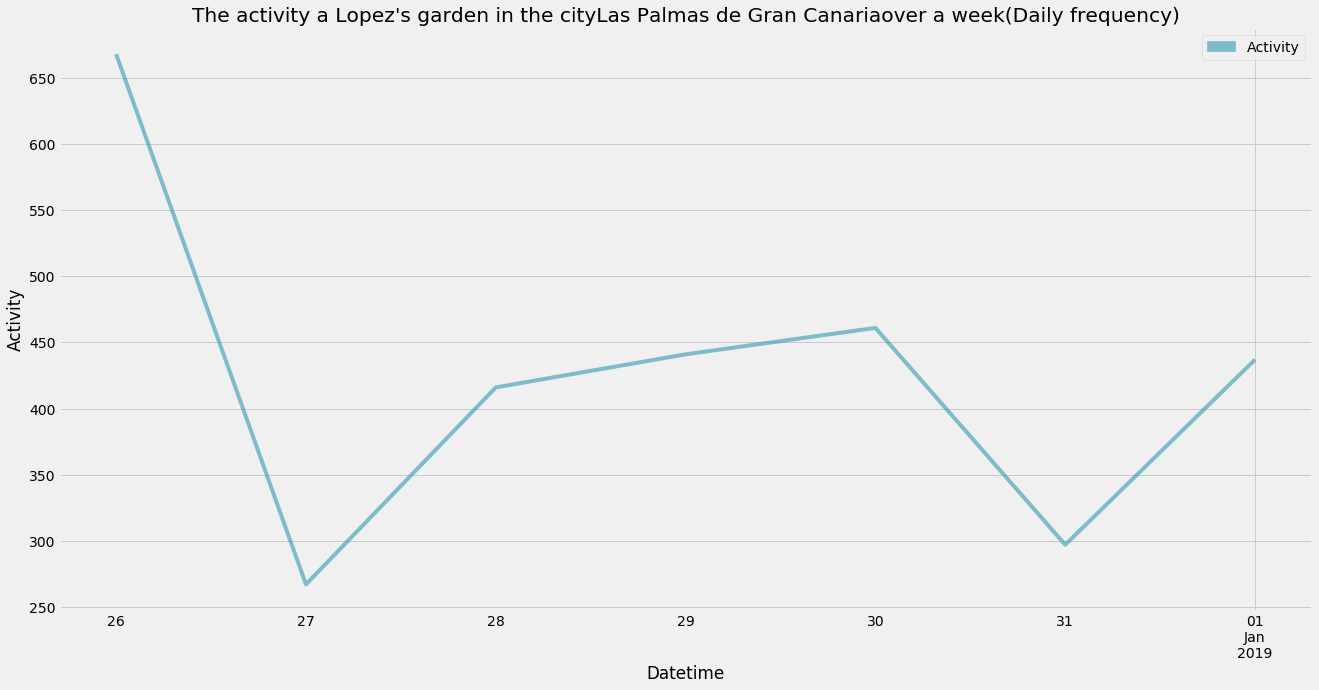

In [80]:
plt.ylabel('Activity')
plt.title("The activity a "+str(garden)+" in the city"+str(city)+"over a week(Daily frequency)")
activity_day.plot(figsize=(20, 10), color=(0.2, 0.6, 0.7, 0.6))
label1 = mpatches.Patch(color=(0.2, 0.6, 0.7, 0.6), label='Activity')
plt.legend(handles=[label1])
plt.savefig('./graphs/Activity_day.png')

### B. Weather Data 
<a id="wplt"></a>

<Figure size 720x504 with 0 Axes>

(-0.5, 799.5, 499.5, -0.5)

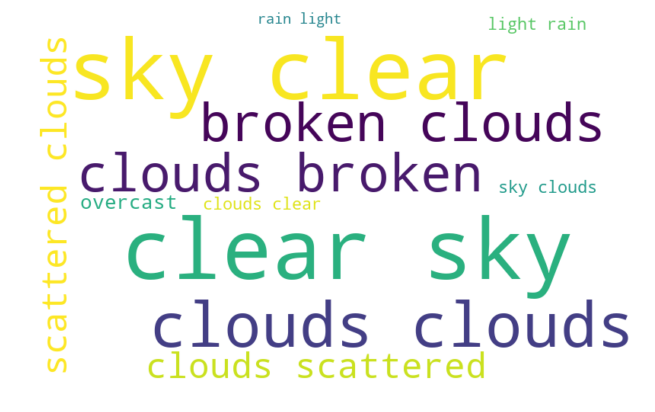

In [52]:
all_words = ' '.join([text for text in Weather_data_words["Weather"]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=15, background_color="white").generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
wordcloud.to_file("./graphs/wordmap.png")
plt.axis('off')
plt.show()

<Figure size 1440x720 with 0 Axes>

Text(0,0.5,'Values')

Text(0.5,1,'The weather at Las Palmas de Gran Canaria')

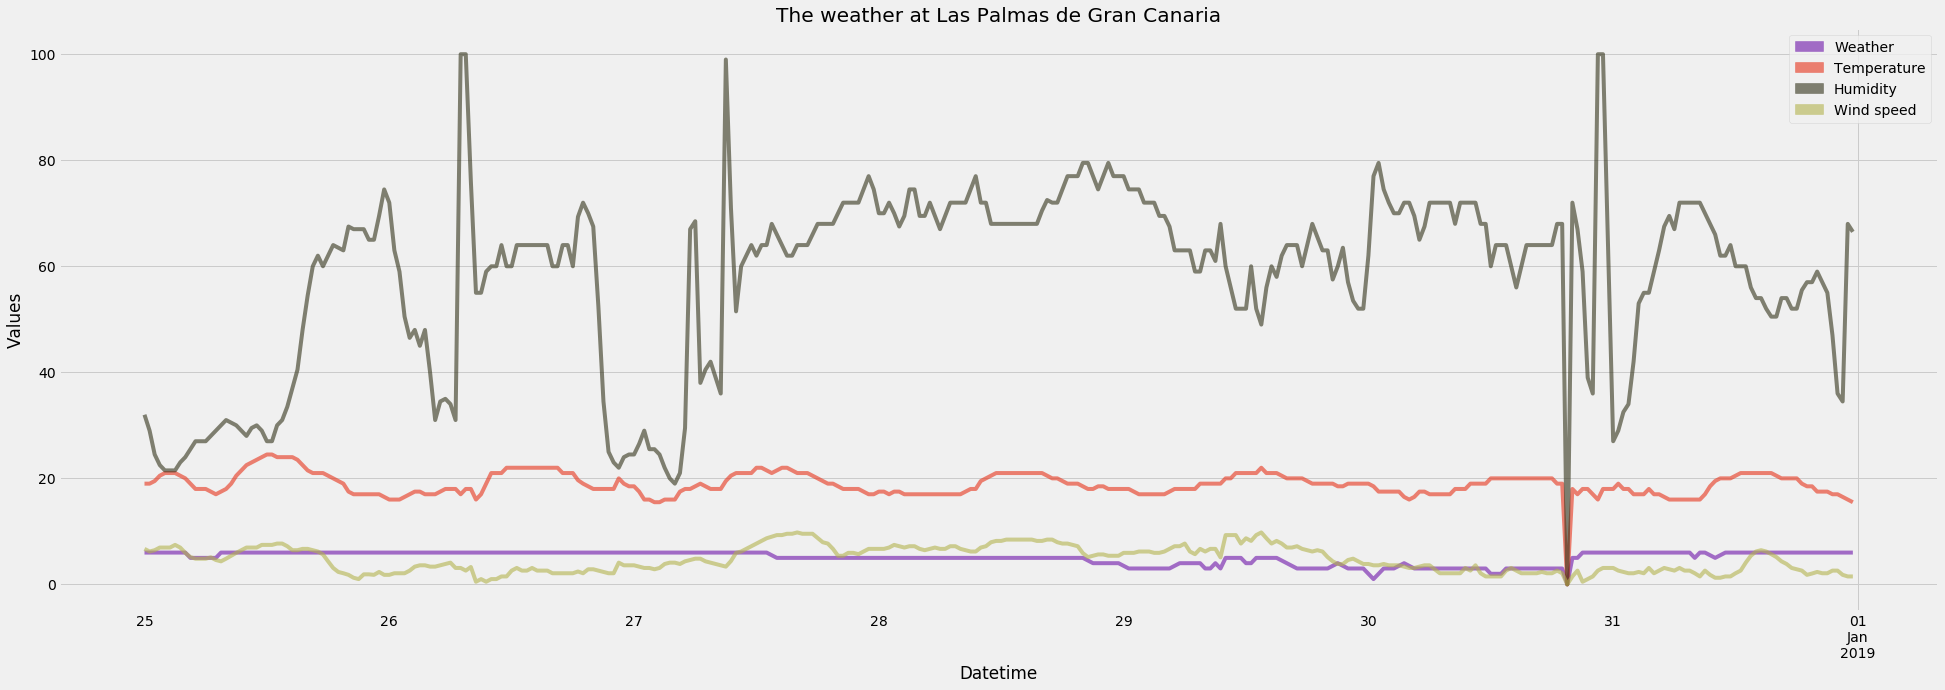

In [167]:
city = "Las Palmas de Gran Canaria"

plt.figure(figsize=(20, 10))
plt.ylabel('Values')
plt.title("The weather at "+str(city))
w_halfhour.Weather.plot(figsize=(30, 10), color=(0.5, 0.2, 0.7, 0.7))
w_halfhour.temperature.plot(figsize=(30, 10), color=(0.9, 0.2, 0.1, 0.6))
w_halfhour.humidity.plot(figsize=(30, 10), color=(0.2, 0.2, 0.1, 0.6))
w_halfhour.Wind_speed.plot(figsize=(30, 10), color=(0.7, 0.7, 0.3, 0.6))

label1 = mpatches.Patch(color=(0.5, 0.2, 0.7, 0.7), label='Weather')
label2 = mpatches.Patch(color=(0.9, 0.2, 0.1, 0.6), label='Temperature')
label3 = mpatches.Patch(color=(0.2, 0.2, 0.1, 0.6), label='Humidity')
label4 = mpatches.Patch(color=(0.7, 0.7, 0.3, 0.6), label='Wind speed')
plt.legend(handles=[label1,label2,label3,label4])

<Figure size 1440x720 with 0 Axes>

Text(0,0.5,'Values')

Text(0.5,1,'The weather at Las Palmas de Gran Canaria')

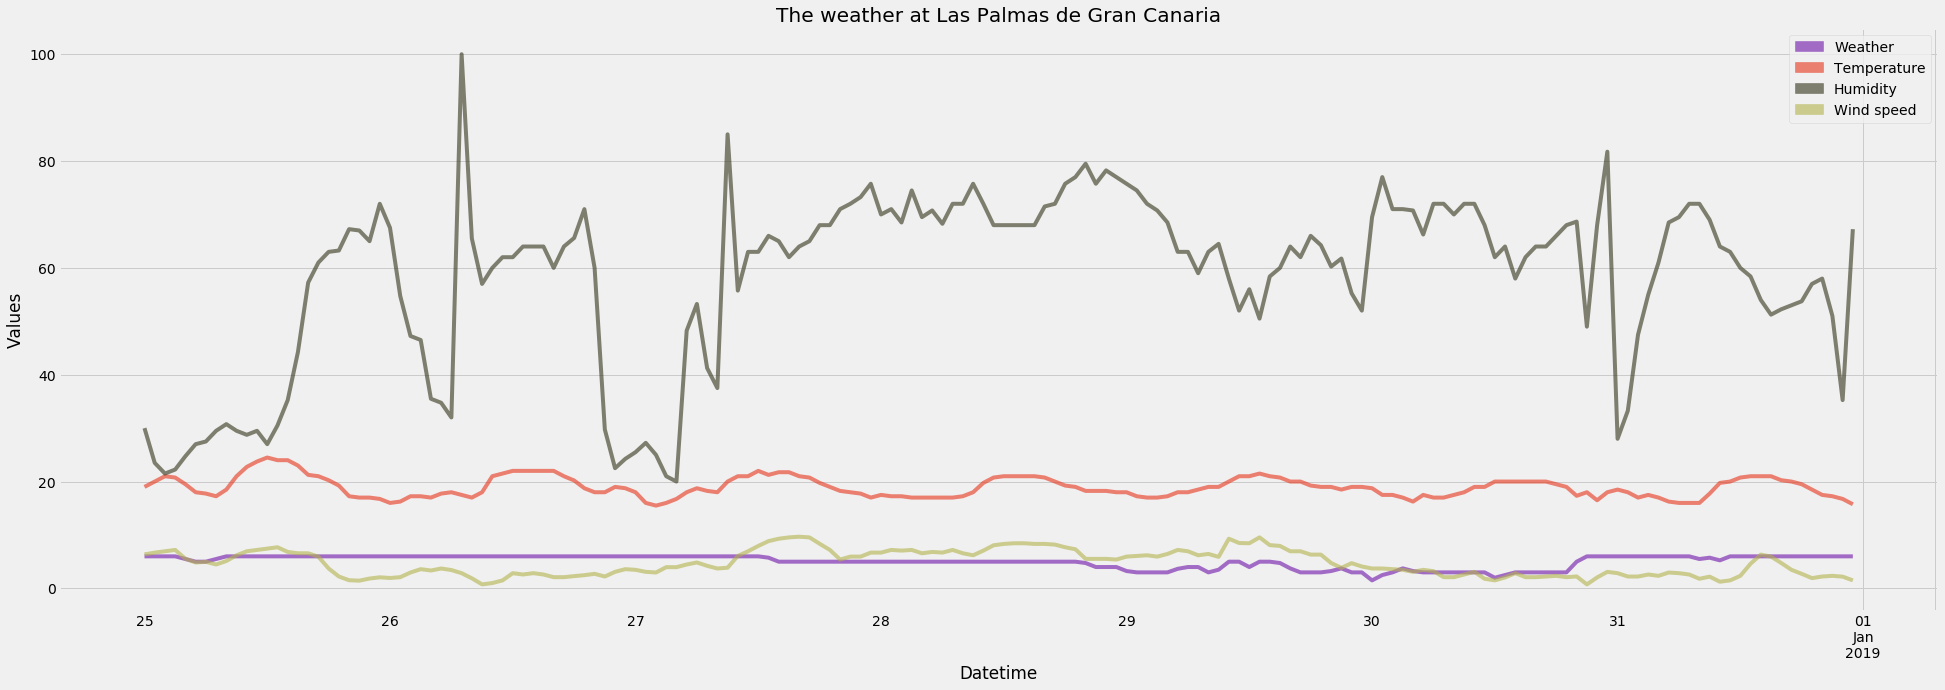

In [165]:
city = "Las Palmas de Gran Canaria"

plt.figure(figsize=(20, 10))
plt.ylabel('Values')
plt.title("The weather at "+str(city))
w_hour.Weather.plot(figsize=(30, 10), color=(0.5, 0.2, 0.7, 0.7))
w_hour.temperature.plot(figsize=(30, 10), color=(0.9, 0.2, 0.1, 0.6))
w_hour.humidity.plot(figsize=(30, 10), color=(0.2, 0.2, 0.1, 0.6))
w_hour.Wind_speed.plot(figsize=(30, 10), color=(0.7, 0.7, 0.3, 0.6))

label1 = mpatches.Patch(color=(0.5, 0.2, 0.7, 0.7), label='Weather')
label2 = mpatches.Patch(color=(0.9, 0.2, 0.1, 0.6), label='Temperature')
label3 = mpatches.Patch(color=(0.2, 0.2, 0.1, 0.6), label='Humidity')
label4 = mpatches.Patch(color=(0.7, 0.7, 0.3, 0.6), label='Wind speed')
plt.legend(handles=[label1,label2,label3,label4])
plt.savefig('./graphs/Weather_hour.png')

<Figure size 1440x720 with 0 Axes>

Text(0,0.5,'Values')

Text(0.5,1,'The weather at Las Palmas de Gran Canaria')

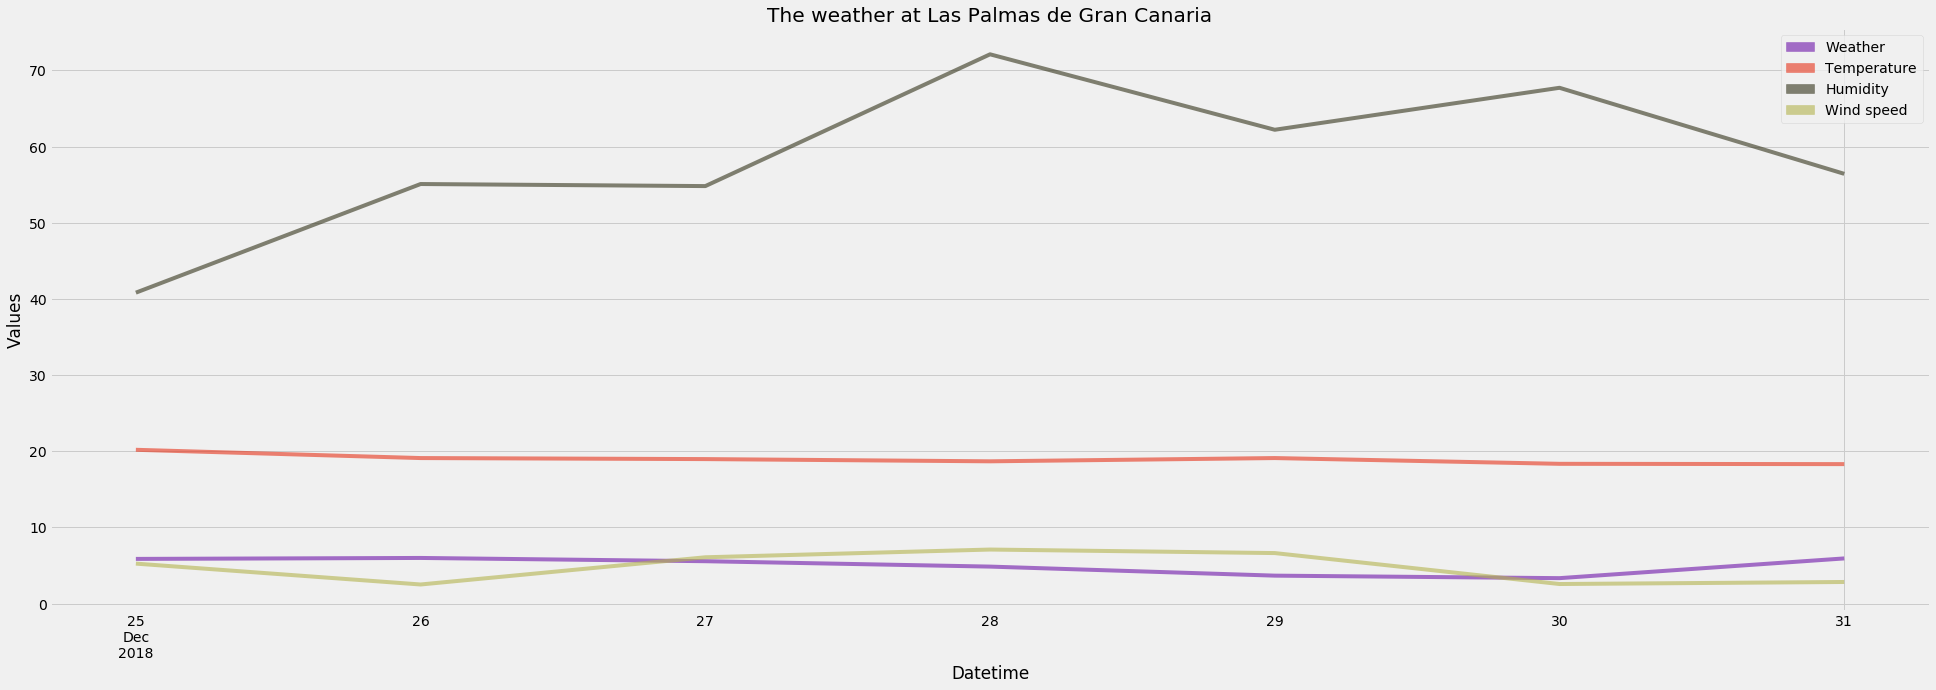

In [166]:
city = "Las Palmas de Gran Canaria"

plt.figure(figsize=(20, 10))
plt.ylabel('Values')
plt.title("The weather at "+str(city))
w_day.Weather.plot(figsize=(30, 10), color=(0.5, 0.2, 0.7, 0.7))
w_day.temperature.plot(figsize=(30, 10), color=(0.9, 0.2, 0.1, 0.6))
w_day.humidity.plot(figsize=(30, 10), color=(0.2, 0.2, 0.1, 0.6))
w_day.Wind_speed.plot(figsize=(30, 10), color=(0.7, 0.7, 0.3, 0.6))

label1 = mpatches.Patch(color=(0.5, 0.2, 0.7, 0.7), label='Weather')
label2 = mpatches.Patch(color=(0.9, 0.2, 0.1, 0.6), label='Temperature')
label3 = mpatches.Patch(color=(0.2, 0.2, 0.1, 0.6), label='Humidity')
label4 = mpatches.Patch(color=(0.7, 0.7, 0.3, 0.6), label='Wind speed')
plt.legend(handles=[label1,label2,label3,label4])
plt.savefig('./graphs/Weather_day.png')

### C. Data per day 
<a id="dplt"></a>

Tuesday 25th December

<Figure size 2160x720 with 0 Axes>

Text(0.5,0,'Values')

Text(0,0.5,'Dates')

Text(0.5,1,"The activity a Lopez's gardenin the cityLas Palmas de Gran Canariaover a week(Hourly frequency)")

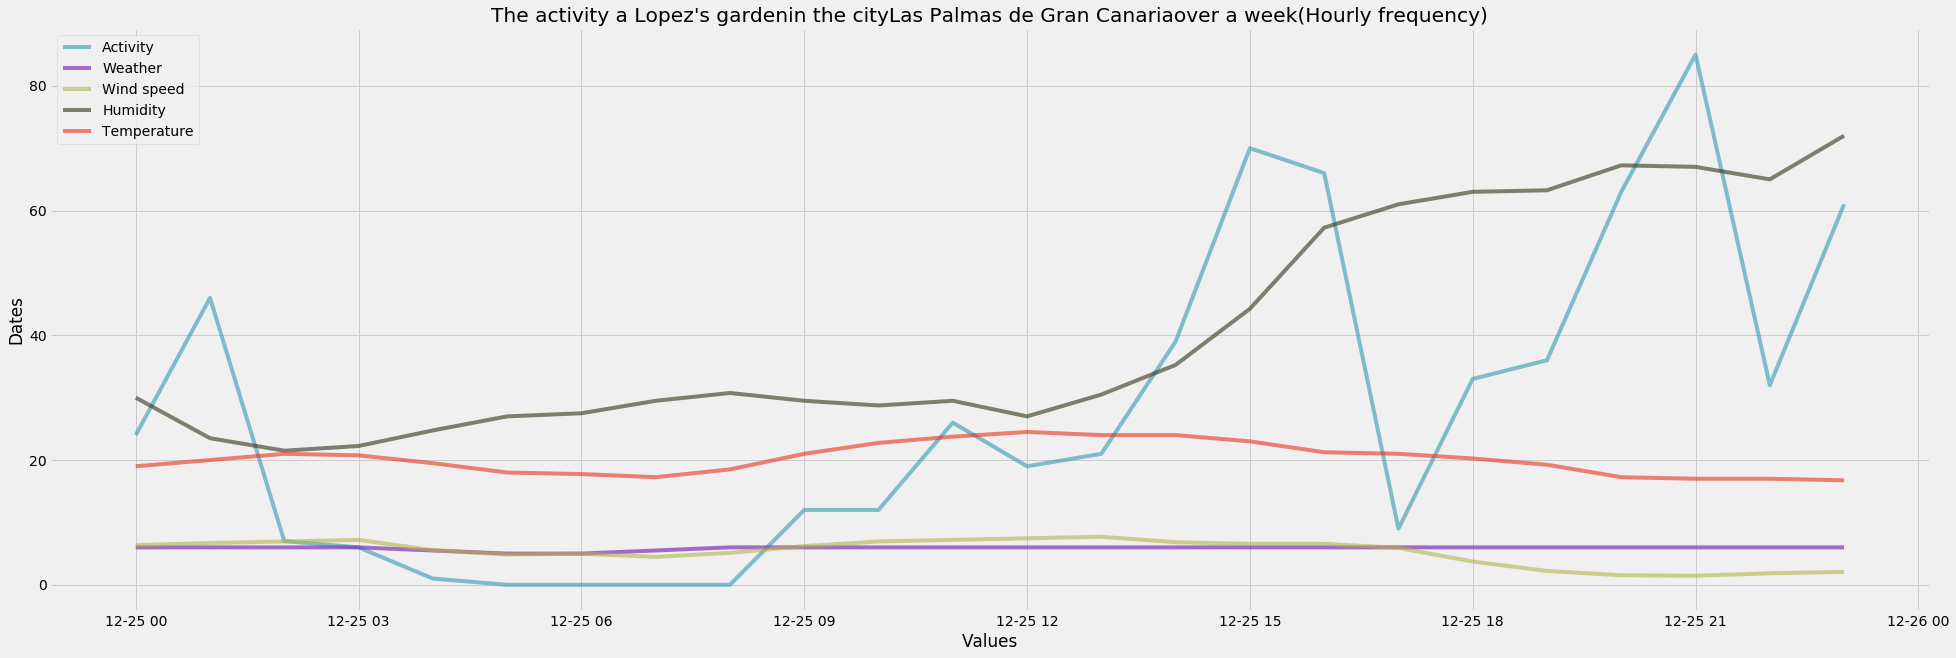

In [171]:
Tuesday_activity = activity_hour.loc['25/12/2018 00:00:00':'25/12/2018 23:00:00']
Tuesday_weather = w_hour.loc['25/12/2018 00:00:00':'25/12/2018 23:00:00']
garden = "Lopez's garden"
city = "Las Palmas de Gran Canaria"

plt.figure(figsize=(30, 10))
plt.xlabel('Values')
plt.ylabel('Dates')
plt.title("The activity a "+str(garden)+"in the city"+str(city)+"over a week(Hourly frequency)")
plt.plot(Tuesday_activity, color=(0.2, 0.6, 0.7, 0.6), label='Activity')
plt.plot(Tuesday_weather.Weather,color=(0.5, 0.2, 0.7, 0.7), label="Weather")
plt.plot(Tuesday_weather.Wind_speed, color=(0.7, 0.7, 0.3, 0.6), label="Wind speed")
plt.plot(Tuesday_weather.humidity,color=(0.2, 0.2, 0.1, 0.6),label="Humidity")
plt.plot(Tuesday_weather.temperature,color=(0.9, 0.2, 0.1, 0.6), label="Temperature")
plt.legend()
plt.savefig('./graphs/Tuesday.png')



Wednesday 26th December

<Figure size 1440x720 with 0 Axes>

Text(0,0.5,'Values')

Text(0.5,1,"The activity a Lopez's gardenin the cityLas Palmas de Gran Canariaover a week(Hourly frequency)")

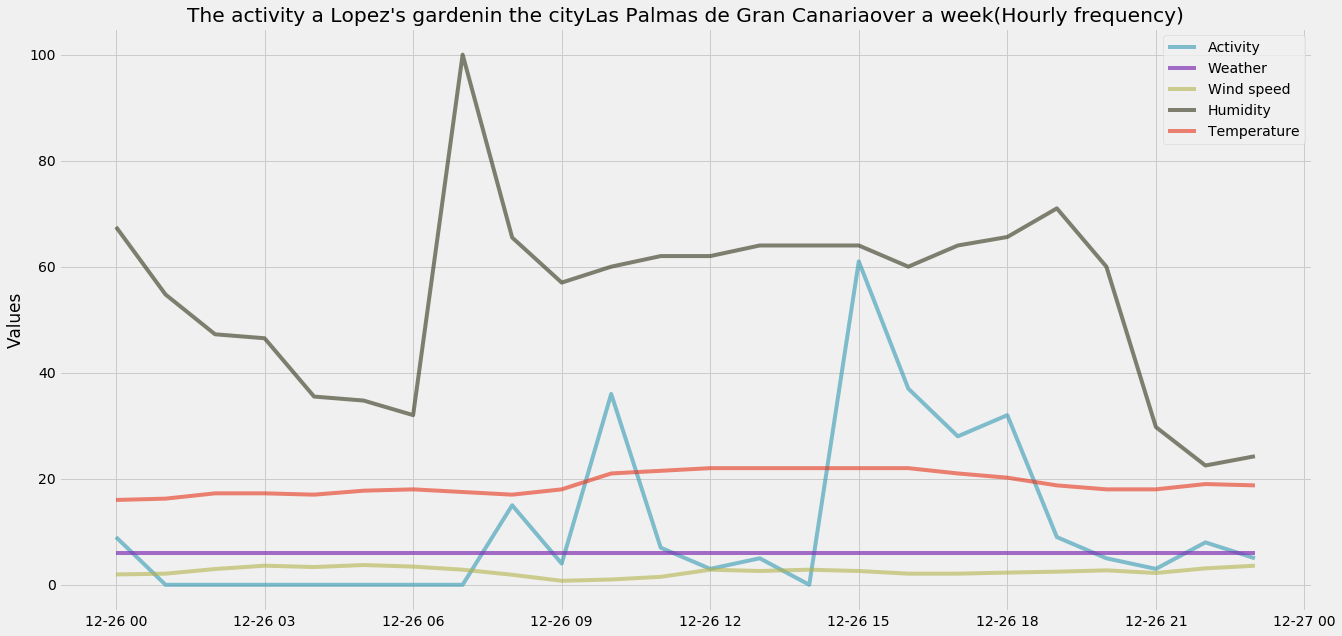

In [215]:
Wednesday_activity = activity_hour.loc['26/12/2018 00:00:00':'26/12/2018 23:00:00']
Wednesday_weather = w_hour.loc['26/12/2018 00:00:00':'26/12/2018 23:00:00']

garden = "Lopez's garden"
city = "Las Palmas de Gran Canaria"

plt.figure(figsize=(20, 10))
plt.ylabel('Values')
plt.title("The activity a "+str(garden)+"in the city"+str(city)+"over a week(Hourly frequency)")
plt.plot(Wednesday_activity,color=(0.2, 0.6, 0.7, 0.6), label='Activity')
plt.plot(Wednesday_weather.Weather,color=(0.5, 0.2, 0.7, 0.7), label="Weather")
plt.plot(Wednesday_weather.Wind_speed, color=(0.7, 0.7, 0.3, 0.6), label="Wind speed")
plt.plot(Wednesday_weather.humidity,color=(0.2, 0.2, 0.1, 0.6),  label="Humidity")
plt.plot(Wednesday_weather.temperature,color=(0.9, 0.2, 0.1, 0.6), label="Temperature")
plt.legend()
plt.savefig('./graphs/Wednesday.png')


Thursday 27th December

<Figure size 1440x720 with 0 Axes>

Text(0,0.5,'Values')

Text(0.5,1,"The activity a Lopez's gardenin the cityLas Palmas de Gran Canariaover a week(Hourly frequency)")

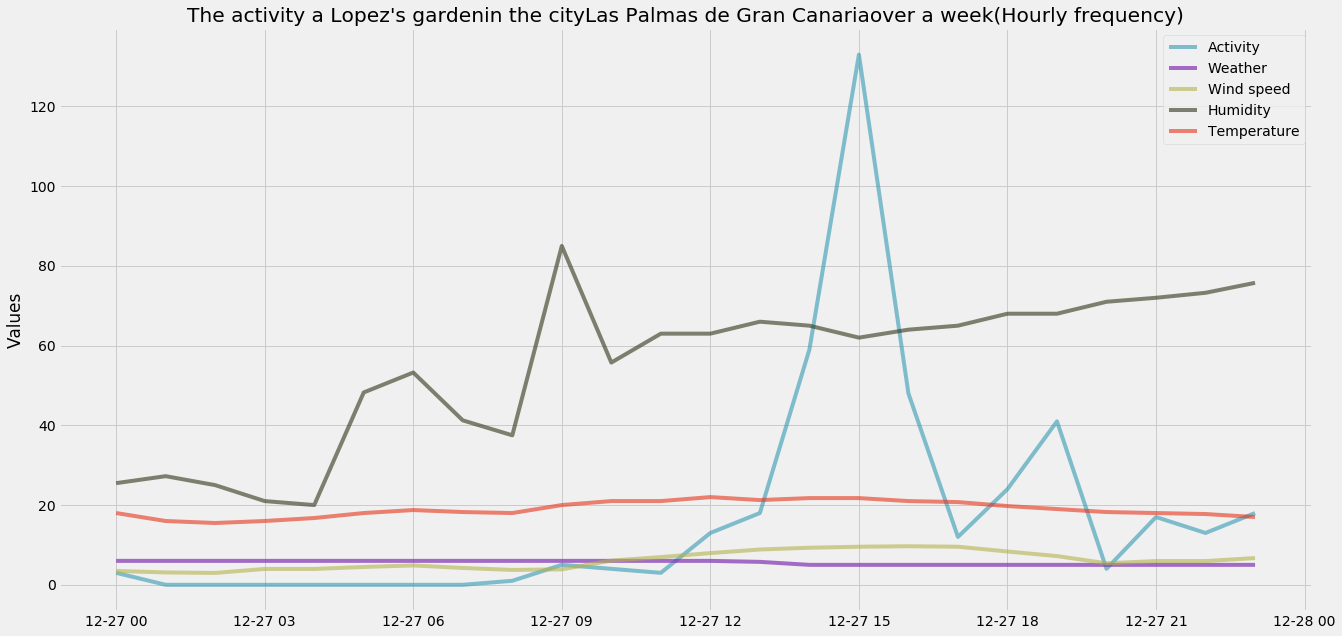

<Figure size 432x288 with 0 Axes>

In [208]:
Thursday_activity = activity_hour.loc['27/12/2018 00:00:00':'27/12/2018 23:00:00']
Thursday_weather = w_hour.loc['27/12/2018 00:00:00':'27/12/2018 23:00:00']

garden = "Lopez's garden"
city = "Las Palmas de Gran Canaria"

plt.figure(figsize=(20, 10))
plt.ylabel('Values')
plt.title("The activity a "+str(garden)+"in the city"+str(city)+"over a week(Hourly frequency)")
plt.plot(Thursday_activity,color=(0.2, 0.6, 0.7, 0.6), label='Activity')
plt.plot(Thursday_weather.Weather,color=(0.5, 0.2, 0.7, 0.7), label="Weather")
plt.plot(Thursday_weather.Wind_speed, color=(0.7, 0.7, 0.3, 0.6), label="Wind speed")
plt.plot(Thursday_weather.humidity,color=(0.2, 0.2, 0.1, 0.6), label="Humidity")
plt.plot(Thursday_weather.temperature,color=(0.9, 0.2, 0.1, 0.6), label="Temperature")
plt.legend()

plt.show()
plt.savefig('./graphs/Thursday.png')


Friday 28th December

<Figure size 1440x720 with 0 Axes>

Text(0,0.5,'Values')

Text(0.5,1,"The activity a Lopez's gardenin the cityLas Palmas de Gran Canariaover a week(Hourly frequency)")

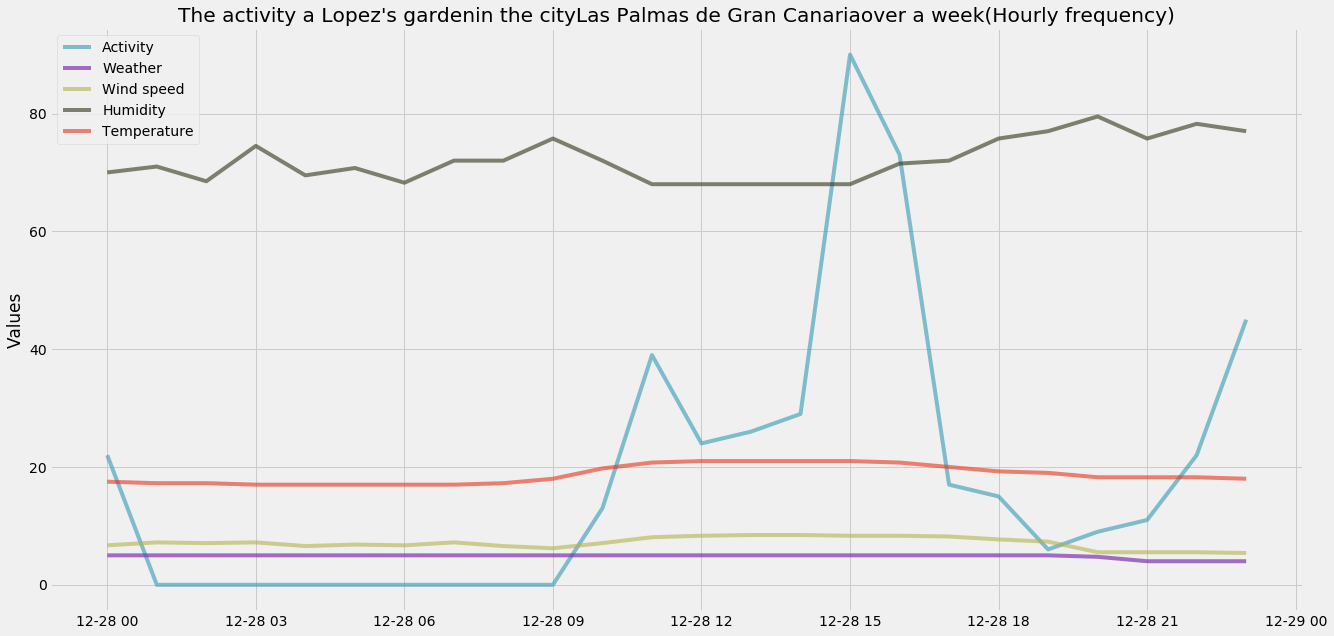

<Figure size 432x288 with 0 Axes>

In [175]:
Friday_activity = activity_hour.loc['28/12/2018 00:00:00':'28/12/2018 23:00:00']
Friday_weather = w_hour.loc['28/12/2018 00:00:00':'28/12/2018 23:00:00']

garden = "Lopez's garden"
city = "Las Palmas de Gran Canaria"

plt.figure(figsize=(20, 10))
plt.ylabel('Values')
plt.title("The activity a "+str(garden)+"in the city"+str(city)+"over a week(Hourly frequency)")
plt.plot(Friday_activity,color=(0.2, 0.6, 0.7, 0.6), label='Activity')
plt.plot(Friday_weather.Weather,color=(0.5, 0.2, 0.7, 0.7), label="Weather")
plt.plot(Friday_weather.Wind_speed, color=(0.7, 0.7, 0.3, 0.6), label="Wind speed")
plt.plot(Friday_weather.humidity,color=(0.2, 0.2, 0.1, 0.6), label="Humidity")
plt.plot(Friday_weather.temperature,color=(0.9, 0.2, 0.1, 0.6), label="Temperature")
plt.legend()

plt.show()
plt.savefig('./graphs/Friday.png')

Saturday 29th December

<Figure size 1440x720 with 0 Axes>

Text(0,0.5,'Values')

Text(0.5,1,"The activity a Lopez's gardenin the cityLas Palmas de Gran Canariaover a week(Hourly frequency)")

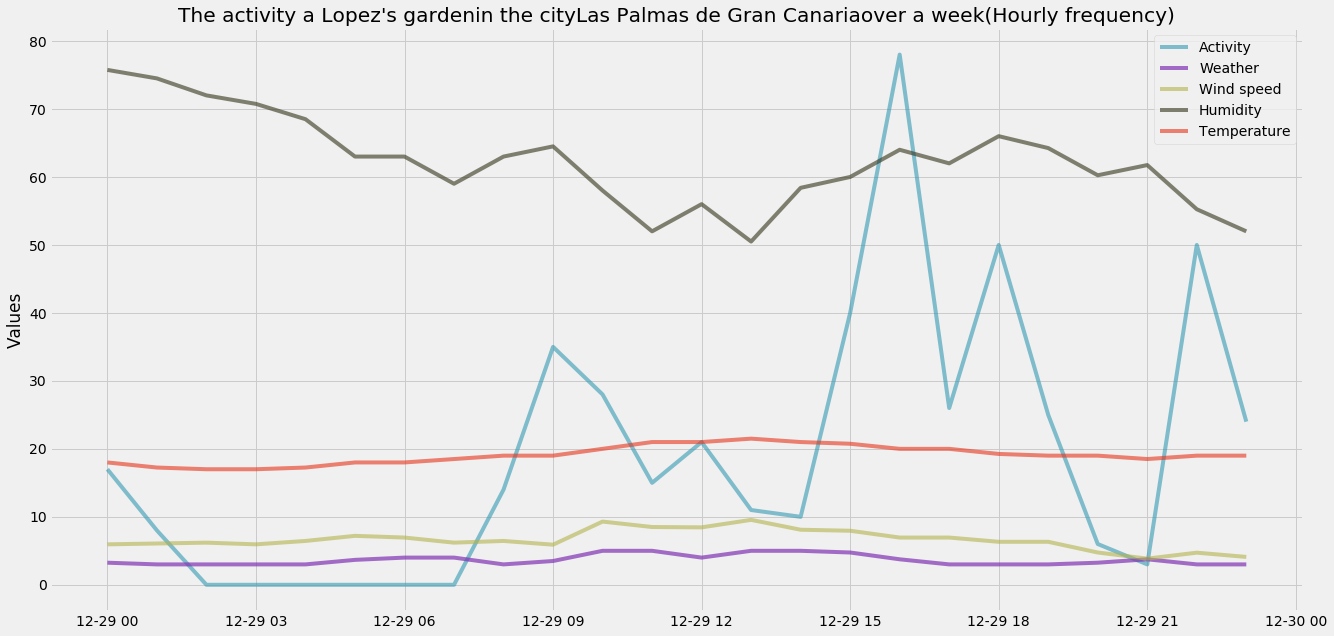

<Figure size 432x288 with 0 Axes>

In [176]:
Saturday_activity = activity_hour.loc['29/12/2018 00:00:00':'29/12/2018 23:00:00']
Saturday_weather = w_hour.loc['29/12/2018 00:00:00':'29/12/2018 23:00:00']

garden = "Lopez's garden"
city = "Las Palmas de Gran Canaria"

plt.figure(figsize=(20, 10))
plt.ylabel('Values')
plt.title("The activity a "+str(garden)+"in the city"+str(city)+"over a week(Hourly frequency)")
plt.plot(Saturday_activity,color=(0.2, 0.6, 0.7, 0.6), label='Activity')
plt.plot(Saturday_weather.Weather,color=(0.5, 0.2, 0.7, 0.7), label="Weather")
plt.plot(Saturday_weather.Wind_speed, color=(0.7, 0.7, 0.3, 0.6), label="Wind speed")
plt.plot(Saturday_weather.humidity,color=(0.2, 0.2, 0.1, 0.6), label="Humidity")
plt.plot(Saturday_weather.temperature,color=(0.9, 0.2, 0.1, 0.6), label="Temperature")
plt.legend()

plt.show()
plt.savefig('./graphs/Saturday.png')


Sunday 30th December

<Figure size 1440x720 with 0 Axes>

Text(0,0.5,'Values')

Text(0.5,1,"The activity a Lopez's gardenin the cityLas Palmas de Gran Canariaover a week(Hourly frequency)")

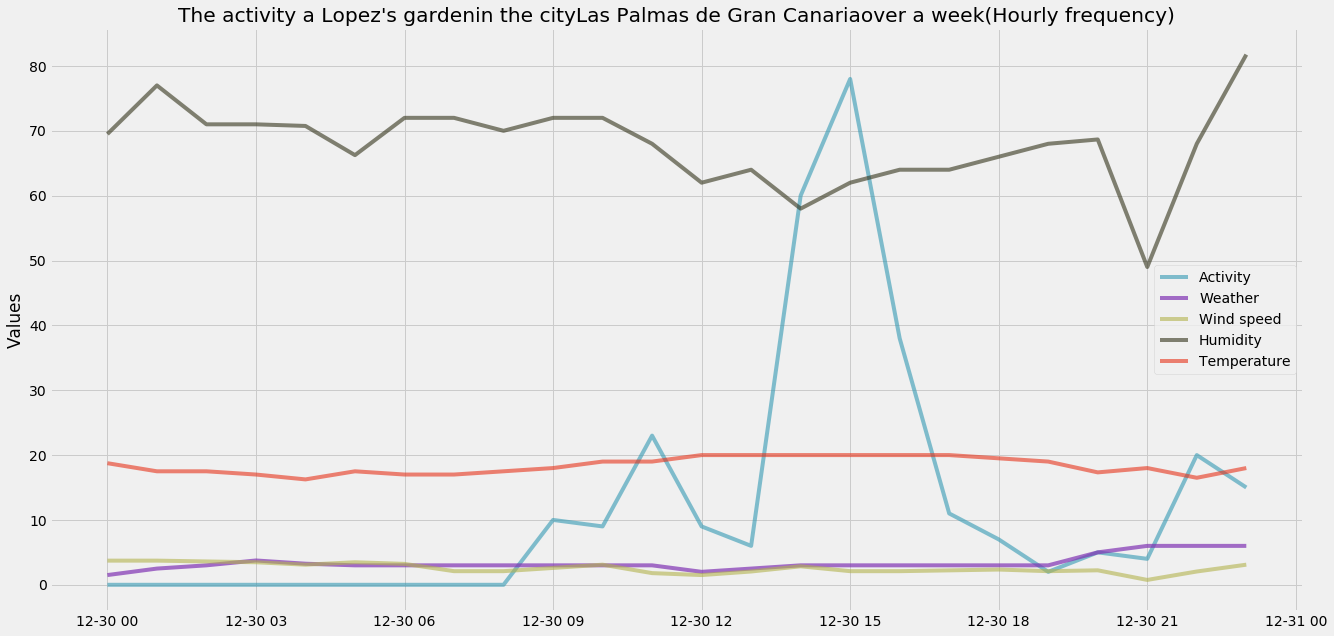

<Figure size 432x288 with 0 Axes>

In [177]:
Sunday_activity = activity_hour.loc['30/12/2018 00:00:00':'30/12/2018 23:00:00']
Sunday_weather = w_hour.loc['30/12/2018 00:00:00':'30/12/2018 23:00:00']

garden = "Lopez's garden"
city = "Las Palmas de Gran Canaria"

plt.figure(figsize=(20, 10))
plt.ylabel('Values')
plt.title("The activity a "+str(garden)+"in the city"+str(city)+"over a week(Hourly frequency)")
plt.plot(Sunday_activity,color=(0.2, 0.6, 0.7, 0.6), label='Activity')
plt.plot(Sunday_weather.Weather,color=(0.5, 0.2, 0.7, 0.7), label="Weather")
plt.plot(Sunday_weather.Wind_speed, color=(0.7, 0.7, 0.3, 0.6), label="Wind speed")
plt.plot(Sunday_weather.humidity,color=(0.2, 0.2, 0.1, 0.6), label="Humidity")
plt.plot(Sunday_weather.temperature,color=(0.9, 0.2, 0.1, 0.6), label="Temperature")
plt.legend()

plt.show()
plt.savefig('./graphs/Sunday.png')

Monday 31st December

<Figure size 1440x720 with 0 Axes>

Text(0,0.5,'Values')

Text(0.5,1,"The activity a Lopez's gardenin the cityLas Palmas de Gran Canariaover a week(Hourly frequency)")

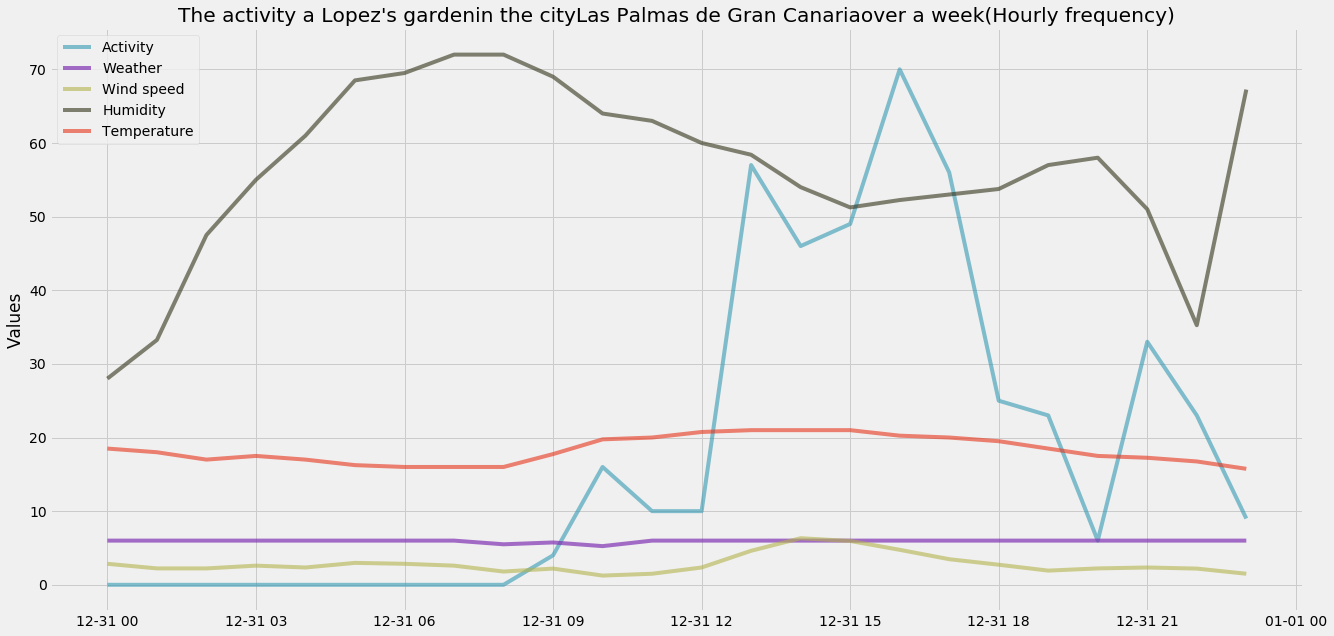

<Figure size 432x288 with 0 Axes>

In [178]:
Monday_activity = activity_hour.loc['31/12/2018 00:00:00':'31/12/2018 23:00:00']
Monday_weather = w_hour.loc['31/12/2018 00:00:00':'31/12/2018 23:00:00']

garden = "Lopez's garden"
city = "Las Palmas de Gran Canaria"

plt.figure(figsize=(20, 10))
plt.ylabel('Values')
plt.title("The activity a "+str(garden)+"in the city"+str(city)+"over a week(Hourly frequency)")
plt.plot(Monday_activity,color=(0.2, 0.6, 0.7, 0.6), label='Activity')
plt.plot(Monday_weather.Weather,color=(0.5, 0.2, 0.7, 0.7), label="Weather")
plt.plot(Monday_weather.Wind_speed, color=(0.7, 0.7, 0.3, 0.6), label="Wind speed")
plt.plot(Monday_weather.humidity,color=(0.2, 0.2, 0.1, 0.6), label="Humidity")
plt.plot(Monday_weather.temperature,color=(0.9, 0.2, 0.1, 0.6), label="Temperature")
plt.legend()

plt.show()
plt.savefig('./graphs/Monday.png')

### D. Normalisation
<a id="cplt"></a>

Below maximumns and minimumns per hour and day 

In [181]:
Activity_range = (activity_hour.loc[activity_hour.idxmax()],activity_hour.loc[activity_hour.idxmin()])
Weather_range = (w_hour.Weather.loc[w_hour.Weather.idxmax()],w_hour.Weather.loc[w_hour.Weather.idxmin()])
Temperature_range = (w_hour.temperature.loc[w_hour.temperature.idxmax()],w_hour.temperature.loc[w_hour.temperature.idxmin()])
Windspeed_range = (w_hour.Wind_speed.loc[w_hour.Wind_speed.idxmax()],w_hour.Wind_speed.loc[w_hour.Wind_speed.idxmin()])
Humidity_range = (w_hour.humidity.loc[w_hour.humidity.idxmax()],w_hour.humidity.loc[w_hour.humidity.idxmin()])

Activity_range
Weather_range
Temperature_range
Windspeed_range
Humidity_range

(133, 0)

(6.0, 1.5)

(24.5, 15.5)

(9.6750000000000007, 0.75)

(100.0, 20.0)

In [180]:
Activity_day_range = (activity_day.loc[activity_day.idxmax()],activity_day.loc[activity_day.idxmin()])
Weather_day_range = (w_day.Weather.loc[w_day.Weather.idxmax()],w_day.Weather.loc[w_day.Weather.idxmin()])
Temperature_day_range = (w_day.temperature.loc[w_day.temperature.idxmax()],w_day.temperature.loc[w_day.temperature.idxmin()])
Windspeed_day_range = (w_day.Wind_speed.loc[w_day.Wind_speed.idxmax()],w_day.Wind_speed.loc[w_day.Wind_speed.idxmin()])
Humidity_day_range = (w_day.humidity.loc[w_day.humidity.idxmax()],w_day.humidity.loc[w_day.humidity.idxmin()])

Activity_day_range
Weather_day_range
Temperature_day_range
Windspeed_day_range
Humidity_day_range

(668, 267)

(6.0, 3.347826086956522)

(20.199999999999999, 18.319587628865978)

(7.1031250000000057, 2.5152083333333302)

(72.125, 40.831578947368421)

Normalisation for comparison 

Text(0.5,1,"The weather and activity in the cityLopez's garden over a week(Hourly) frequency)")

Text(0,0.5,'Values')

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167]),
 <a list of 168 Text xticklabel objects>)

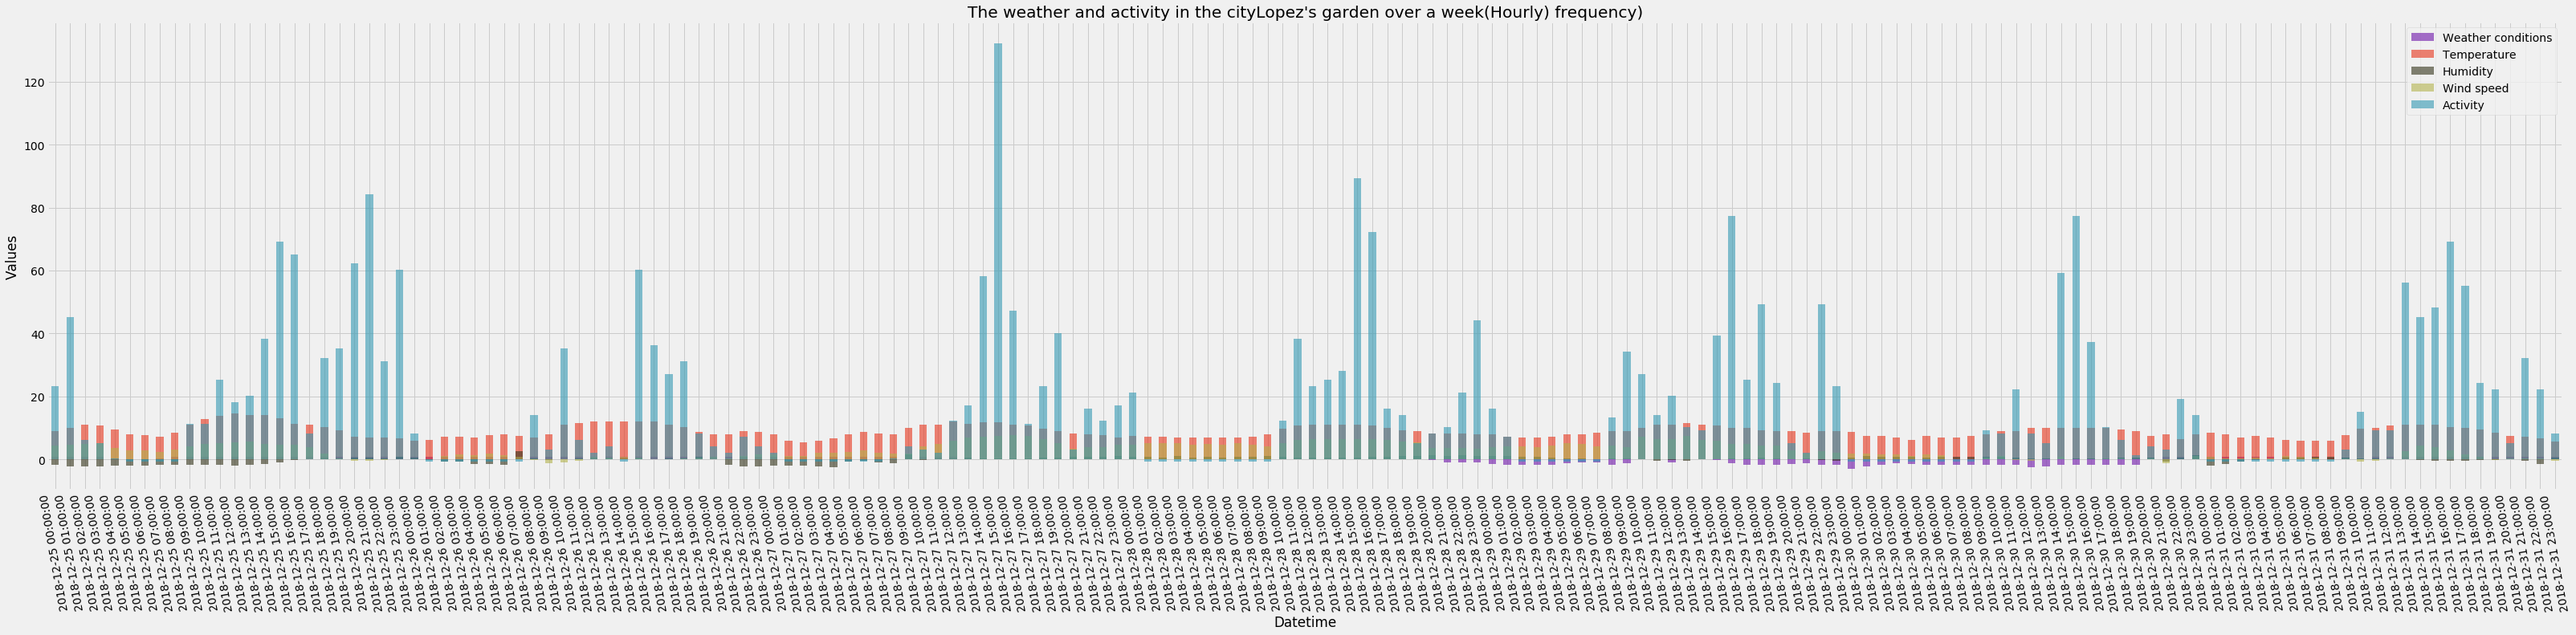

<Figure size 432x288 with 0 Axes>

In [190]:
garden = "Lopez's garden"
city = "Las Palmas de Gran Canaria"

plt.title("The weather and activity in the city"+str(garden)+" over a week(Hourly) frequency)")
plt.ylabel('Values')
n_weather.plot.bar(color=(0.5, 0.2, 0.7, 0.7),figsize=(50, 10),label ="Weather conditions") 
n_temperature.plot.bar(color=(0.9, 0.2, 0.1, 0.6), figsize=(50, 10),label ="Temperature") 
n_humidity.plot.bar(color=(0.2, 0.2, 0.1, 0.6), figsize=(50, 10),label ="Humidity")
n_wind_speed.plot.bar(color=(0.7, 0.7, 0.3, 0.6), figsize=(50, 10),label ="Wind speed")
n_activity.plot.bar(color=(0.2, 0.6, 0.7, 0.6),figsize=(50,10),label = 'Activity')
plt.legend()
plt.xticks(rotation=100)
plt.show()

plt.savefig('./graphs/Normalised_data_perhour.png')


Text(0.5,1,'Normalised weather DataLas Palmas de Gran Canaria')

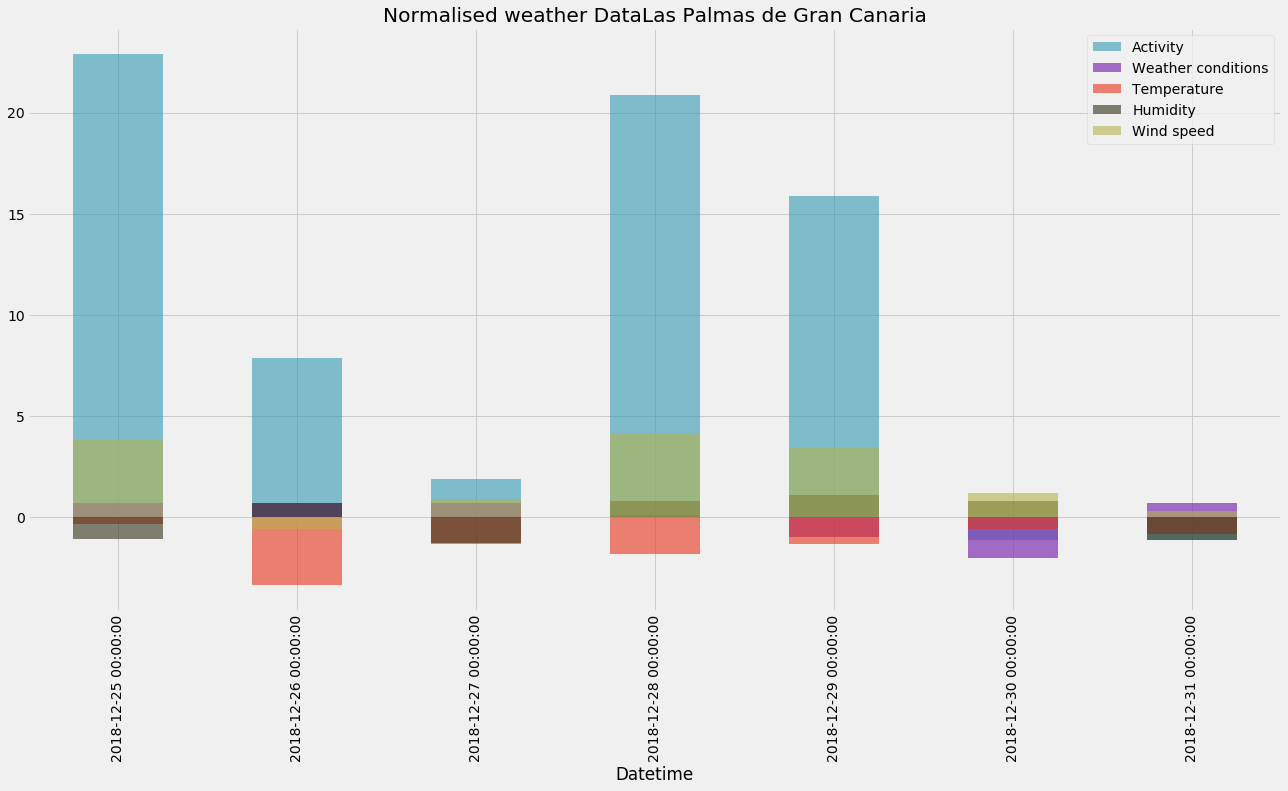

In [193]:
city = "Las Palmas de Gran Canaria"


n_activity = ((activity_hour.asfreq('D')) - np.mean(activity_hour.asfreq('D'))/np.std(activity_hour.asfreq('D')))
n_weather = (w_hour['Weather'].asfreq('D') - np.mean(w_hour['Weather'].asfreq('D')))/np.std(w_hour['Weather'].asfreq('D'))
n_temperature = (w_hour['temperature'].asfreq('D') - np.mean(w_hour['temperature'].asfreq('D'))/np.std(w_hour['temperature'].asfreq('D')))
n_humidity = (w_hour['humidity'].asfreq('D') - np.mean(w_hour['humidity'].asfreq('D')))/np.std(w_hour['humidity'].asfreq('D'))
n_wind_speed = (w_hour['Wind_speed'].asfreq('D') - np.mean(w_hour['Wind_speed'].asfreq('D'))/np.std(w_hour['Wind_speed'].asfreq('D')))


n_activity.plot.bar(color=(0.2, 0.6, 0.7, 0.6), label ="Activity",figsize=(20, 10))
n_weather.plot.bar(color=(0.5, 0.2, 0.7, 0.7),label ="Weather conditions",figsize=(20, 10)) 
n_temperature.plot.bar(color=(0.9, 0.2, 0.1, 0.6), label ="Temperature",figsize=(20, 10)) 
n_humidity.plot.bar(color=(0.2, 0.2, 0.1, 0.6), label ="Humidity",figsize=(20, 10))
n_wind_speed.plot.bar(color=(0.7, 0.7, 0.3, 0.6), label ="Wind speed",figsize=(20, 10))
plt.title('Normalised weather Data'+str(city))

plt.legend()
plt.show()

## 3. Autocorrelation 
<a id="ac"></a>

### A. Presence Data 
<a id="acp"></a>

In [194]:
pac1 = activity_hour.corr(activity_hour)
pac2 = activity_day.corr(activity_day)
pac1, pac2

(0.99999999999999989, 1.0)

In [202]:
acf = plot_acf(activity_hour, lags=50)
acf.set_figheight(4)
acf.set_figwidth(12)
plt.show()


NameError: name 'plot_acf' is not defined

### B. Weather Data
<a id="wcp"></a>

In [36]:
wac1 = w_hour["Weather"].corr(w_hour["Wind_speed"])
wac2 = w_hour["Weather"].corr(w_hour["temperature"])
wac3 = w_hour["Weather"].corr(w_hour["humidity"])
wac4 = w_hour["Wind_speed"].corr(w_hour["temperature"])
wac5 = w_hour["Wind_speed"].corr(w_hour["humidity"])
wac6 = w_hour["temperature"].corr(w_hour["humidity"])
wac1,wac2,wac3,wac4,wac5,wac6

(-0.094673991665145577,
 0.10766274078242508,
 -0.40331986836036138,
 0.40999706980789263,
 0.02106279867268426,
 -0.15728537620248736)

In [38]:
acf = plot_acf(w_hour["Weather"], lags=50)
acf.set_figheight(4)
acf.set_figwidth(12)
plt.show()

acf = plot_acf(w_hour["Wind_speed"], lags=50)
acf.set_figheight(4)
acf.set_figwidth(12)
plt.show()
acf = plot_acf(w_hour["temperature"], lags=50)
acf.set_figheight(4)
acf.set_figwidth(12)
plt.show()
acf = plot_acf(w_hour["humidity"], lags=50)
acf.set_figheight(4)
acf.set_figwidth(12)
plt.show()

NameError: name 'plot_acf' is not defined

## 4. Correlation 
<a id="c"></a>

In [40]:
cc1 = w_hour["Weather"].corr(activity_hour)
cc2 = w_hour["humidity"].corr(activity_hour)
cc3 = w_hour["Wind_speed"].corr(activity_hour)
cc4 = w_hour["temperature"].corr(activity_hour)
                                        
cc1,cc2,cc3,cc4


(0.022600456123489484,
 0.091598500493599036,
 0.2077862058778801,
 0.43274643188050466)

In [216]:
Tc1 = Tuesday_weather.Weather.corr(Tuesday_activity)
Tc2 = Tuesday_weather.humidity.corr(Tuesday_activity)
Tc3 = Tuesday_weather.Wind_speed.corr(Tuesday_activity)
Tc4 = Tuesday_weather.temperature.corr(Tuesday_activity)

Wc1 = Wednesday_weather.Weather.corr(Wednesday_activity)
Wc2 = Wednesday_weather.humidity.corr(Wednesday_activity)
Wc3 = Wednesday_weather.Wind_speed.corr(Wednesday_activity)
Wc4 = Wednesday_weather.temperature.corr(Wednesday_activity)

Thc1 = Thursday_weather.Weather.corr(Thursday_activity)
Thc2 = Thursday_weather.humidity.corr(Thursday_activity)
Thc3 = Thursday_weather.Wind_speed.corr(Thursday_activity)
Thc4 = Thursday_weather.temperature.corr(Thursday_activity)

Fc1 = Friday_weather.Weather.corr(Friday_activity)
Fc2 = Friday_weather.humidity.corr(Friday_activity)
Fc3 = Friday_weather.Wind_speed.corr(Friday_activity)
Fc4 = Friday_weather.temperature.corr(Friday_activity)

Sc1 = Saturday_weather.Weather.corr(Saturday_activity)
Sc2 = Saturday_weather.humidity.corr(Saturday_activity)
Sc3 = Saturday_weather.Wind_speed.corr(Saturday_activity)
Sc4 = Saturday_weather.temperature.corr(Saturday_activity)

Suc1 = Sunday_weather.Weather.corr(Sunday_activity)
Suc2 = Sunday_weather.humidity.corr(Sunday_activity)
Suc3 = Sunday_weather.Wind_speed.corr(Sunday_activity)
Suc4 = Sunday_weather.temperature.corr(Sunday_activity)

Mc1 = Monday_weather.Weather.corr(Monday_activity)
Mc2 = Monday_weather.humidity.corr(Monday_activity)
Mc3 = Monday_weather.Wind_speed.corr(Monday_activity)
Mc4 = Monday_weather.temperature.corr(Monday_activity)
                                        
Tc1,Tc2,Tc3,Tc4
Wc1,Wc2,Wc3,Wc4
Thc1,Thc2,Thc3,Thc4
Fc1,Fc2,Fc3,Fc4
Sc1,Sc2,Sc3,Sc4
Suc1,Suc2,Suc3,Suc4
Mc1,Mc2,Mc3,Mc4

(0.46284047020020158,
 0.67229054226760443,
 -0.40454504984448825,
 -0.07450699042066386)

(nan, 0.25313357411780052, -0.36151542947775672, 0.53256978351215067)

(-0.5805557715933376,
 0.33009105237711783,
 0.66375811895777093,
 0.51174292865991122)

(-0.11182874613638061,
 -0.20455249048518642,
 0.40097078519216239,
 0.69544092715361994)

(-0.0077697107989063265,
 -0.15877176109073851,
 0.0451442285834645,
 0.42416380167866174)

(0.018061597897367353,
 -0.36747568201777248,
 -0.22001840174982695,
 0.53955230869838255)

(0.15296637780370864,
 -0.17907371452867907,
 0.70707951115565471,
 0.69774009886728894)

,Datetime,City,Weather,Wind_speed,humidity,temperature
0,25/12/2018 00:05:15,Las Palmas de Gran Canaria,clear sky,6.7,32,19
1,25/12/2018 00:16:32,Las Palmas de Gran Canaria,clear sky,6.7,32,19
2,25/12/2018 00:31:34,Las Palmas de Gran Canaria,clear sky,6.2,29,19
3,25/12/2018 00:46:37,Las Palmas de Gran Canaria,clear sky,6.2,29,19
4,25/12/2018 01:05:01,Las Palmas de Gran Canaria,clear sky,6.2,25,19
5,25/12/2018 01:24:16,Las Palmas de Gran Canaria,clear sky,6.7,24,20
6,25/12/2018 01:39:18,Las Palmas de Gran Canaria,clear sky,6.7,24,20
7,25/12/2018 01:54:21,Las Palmas de Gran Canaria,clear sky,7.2,21,21
8,25/12/2018 02:09:24,Las Palmas de Gran Canaria,clear sky,7.2,21,21
9,25/12/2018 02:24:27,Las Palmas de Gran Canaria,clear sky,6.7,22,21


Text(0.5,1,'Abalone Feature Correlation')

[Text(0,0,'Sex'),
 Text(0,0,'Length'),
 Text(0,0,'Diam'),
 Text(0,0,'Height'),
 Text(0,0,'Whole'),
 Text(0,0,'Shucked'),
 Text(0,0,'Viscera')]

[Text(0,0,'Sex'),
 Text(0,0,'Length'),
 Text(0,0,'Diam'),
 Text(0,0,'Height'),
 Text(0,0,'Whole'),
 Text(0,0,'Shucked'),
 Text(0,0,'Viscera')]

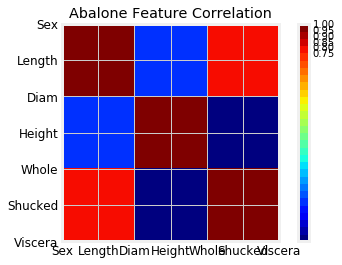

In [21]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Read file into a Pandas dataframe
from pandas import DataFrame, read_csv
a = pd.read_csv('./Data_collected/Raw_data/Cloud_data/Weather_data.csv')
a=a[0:10]
a

from matplotlib import pyplot as plt
from matplotlib import cm as cm
fig = plt.figure()
ax1 = fig.add_subplot(111)
cmap = cm.get_cmap('jet', 30)
cax = ax1.imshow(a.corr(), interpolation="nearest", cmap=cmap)
ax1.grid(True)
plt.title('Abalone Feature Correlation')
labels=['Sex','Length','Diam','Height','Whole','Shucked','Viscera','Shell','Rings',]
ax1.set_xticklabels(labels,fontsize=12)
ax1.set_yticklabels(labels,fontsize=12)
# Add colorbar, make sure to specify tick locations to match desired ticklabels
fig.colorbar(cax, ticks=[.75,.8,.85,.90,.95,1])
plt.show()
    